In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import ContrastiveCorInfoMaxHopfieldSparse
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
# # Best Hyperparameters so far
# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.99999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([0.15, 0.12])}

# neural_lr_start = 0.05
# neural_lr_stop = 0.001
# neural_lr_rule = "constant"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 5
# neural_dynamic_iterations_free = 30
# hopfield_g = 0.5
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

# activation = hard_sigmoid
# architecture = [784, 500, 10]

# beta = 1
# lambda_ = 0.999999
# epsilon = 0.15
# one_over_epsilon = 1 / epsilon
# lr_start = {'ff' : np.array([0.12, 0.04]), 'fb': np.array([0.15, 0.02])}

# neural_lr_start = 0.01
# neural_lr_stop = 0.001
# STlambda_lr_list = [0.0001, 0.000001]
# neural_lr_rule = "divide_by_slow_loop_index"
# neural_lr_decay_multiplier = 0.01
# neural_dynamic_iterations_nudged = 10
# neural_dynamic_iterations_free = 20
# hopfield_g = 0.1
# use_random_sign_beta = True
# use_three_phase = False
# weight_decay = False

activation = hard_sigmoid
architecture = [784, 500, 10]

beta = 1
lambda_ = 0.99999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([1, 0.75]), 'fb': np.array([0.15, 0.12])}

STlambda_lr_list = [1e-6, 0.01]
sparse_layers = [1, 2]
neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 4
neural_dynamic_iterations_free = 20
hopfield_g = 0.5
use_random_sign_beta = True
use_three_phase = False
weight_decay = False

model = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation, sparse_layers = sparse_layers)

In [5]:
_ = evaluateContrastiveCorInfoMaxHopfieldSparse(model, train_loader, hopfield_g,
                                                neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.11888333333333333


In [6]:
# _ = evaluateContrastiveCorInfoMaxHopfieldSparse_topk( model, train_loader, hopfield_g,
#                                                       neural_lr_start, neural_lr_stop, STlambda_lr, 
#                                                       neural_lr_rule, 
#                                                       neural_lr_decay_multiplier, 
#                                                       neural_dynamic_iterations_free, device)

In [7]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 30

for epoch_ in range(n_epochs):
    if epoch_ < 15:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    else:
        lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        take_debug_logs_ = (idx % 500 == 0)
        if use_random_sign_beta:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield( x, y_one_hot, hopfield_g, 
                                             lr, neural_lr_start, neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                             neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                             neural_dynamic_iterations_nudged, beta, 
                                             use_three_phase, take_debug_logs_, weight_decay)
    
    trn_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, train_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                            neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                            neural_lr_decay_multiplier, 
                                                            neural_dynamic_iterations_free, 
                                                            device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    print("Free Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_free)[-1] / np.array(model.layerwise_backward_corinfo_list_free)[-1]))
    print("Nudged Information ratio: {}".format(np.array(model.layerwise_forward_corinfo_list_nudged)[-1] / np.array(model.layerwise_backward_corinfo_list_nudged)[-1]))

3000it [01:33, 31.96it/s]
0it [00:00, ?it/s]

Epoch : 1, Train Accuracy : 0.9425333333333333, Test Accuracy : 0.9459
Free Information ratio: [0.13241639]
Nudged Information ratio: [0.13241591]


3000it [01:34, 31.90it/s]
0it [00:00, ?it/s]

Epoch : 2, Train Accuracy : 0.9590833333333333, Test Accuracy : 0.9567
Free Information ratio: [0.11511327]
Nudged Information ratio: [0.11511208]


3000it [01:34, 31.79it/s]
0it [00:00, ?it/s]

Epoch : 3, Train Accuracy : 0.9686, Test Accuracy : 0.9651
Free Information ratio: [0.12086376]
Nudged Information ratio: [0.12086209]


3000it [01:00, 49.86it/s]
1it [00:00,  6.74it/s]

Epoch : 4, Train Accuracy : 0.9725333333333334, Test Accuracy : 0.9681
Free Information ratio: [0.12858011]
Nudged Information ratio: [0.12857791]


3000it [00:45, 66.26it/s]
1it [00:00,  7.29it/s]

Epoch : 5, Train Accuracy : 0.9763, Test Accuracy : 0.9695
Free Information ratio: [0.09921811]
Nudged Information ratio: [0.09921527]


3000it [00:45, 65.40it/s]
1it [00:00,  7.37it/s]

Epoch : 6, Train Accuracy : 0.9774333333333334, Test Accuracy : 0.9716
Free Information ratio: [0.09446538]
Nudged Information ratio: [0.09446226]


3000it [00:46, 64.84it/s]
1it [00:00,  7.10it/s]

Epoch : 7, Train Accuracy : 0.9754666666666667, Test Accuracy : 0.971
Free Information ratio: [0.07621693]
Nudged Information ratio: [0.07621409]


3000it [00:46, 64.71it/s]
1it [00:00,  6.78it/s]

Epoch : 8, Train Accuracy : 0.9794333333333334, Test Accuracy : 0.973
Free Information ratio: [0.05522114]
Nudged Information ratio: [0.05521862]


1it [00:00,  7.06it/s]/s]

Epoch : 9, Train Accuracy : 0.9810333333333333, Test Accuracy : 0.9723
Free Information ratio: [0.05269618]
Nudged Information ratio: [0.05269383]


3000it [00:46, 64.80it/s]
1it [00:00,  6.64it/s]

Epoch : 10, Train Accuracy : 0.9827, Test Accuracy : 0.9746
Free Information ratio: [0.06339008]
Nudged Information ratio: [0.06338689]


3000it [00:46, 64.58it/s]
1it [00:00,  7.31it/s]

Epoch : 11, Train Accuracy : 0.98285, Test Accuracy : 0.9747
Free Information ratio: [0.0588279]
Nudged Information ratio: [0.05882486]


3000it [00:45, 65.69it/s]
1it [00:00,  6.56it/s]

Epoch : 12, Train Accuracy : 0.9842333333333333, Test Accuracy : 0.9745
Free Information ratio: [0.0487016]
Nudged Information ratio: [0.04869881]


3000it [00:46, 64.42it/s]
1it [00:00,  6.58it/s]

Epoch : 13, Train Accuracy : 0.98535, Test Accuracy : 0.975
Free Information ratio: [0.04673201]
Nudged Information ratio: [0.04672866]


3000it [00:46, 64.61it/s]
1it [00:00,  7.04it/s]

Epoch : 14, Train Accuracy : 0.985, Test Accuracy : 0.9746
Free Information ratio: [0.05566538]
Nudged Information ratio: [0.05566188]


3000it [00:45, 65.65it/s]
1it [00:00,  6.48it/s]

Epoch : 15, Train Accuracy : 0.98485, Test Accuracy : 0.9762
Free Information ratio: [0.0559116]
Nudged Information ratio: [0.05590813]


3000it [00:55, 54.12it/s]
1it [00:00,  7.14it/s]

Epoch : 16, Train Accuracy : 0.9854666666666667, Test Accuracy : 0.9753
Free Information ratio: [0.05197113]
Nudged Information ratio: [0.0519677]


3000it [00:55, 53.88it/s]
1it [00:00,  7.30it/s]

Epoch : 17, Train Accuracy : 0.9861833333333333, Test Accuracy : 0.9762
Free Information ratio: [0.04824828]
Nudged Information ratio: [0.04824419]


3000it [00:46, 65.09it/s]
1it [00:00,  6.93it/s]

Epoch : 18, Train Accuracy : 0.9864666666666667, Test Accuracy : 0.975
Free Information ratio: [0.04628606]
Nudged Information ratio: [0.04628219]


3000it [00:46, 64.70it/s]
1it [00:00,  7.35it/s]

Epoch : 19, Train Accuracy : 0.9864, Test Accuracy : 0.9754
Free Information ratio: [0.05514072]
Nudged Information ratio: [0.05513712]


3000it [00:46, 64.77it/s]
1it [00:00,  6.58it/s]

Epoch : 20, Train Accuracy : 0.9864333333333334, Test Accuracy : 0.9746
Free Information ratio: [0.04067701]
Nudged Information ratio: [0.0406735]


3000it [00:46, 64.45it/s]
1it [00:00,  6.93it/s]

Epoch : 21, Train Accuracy : 0.98645, Test Accuracy : 0.975
Free Information ratio: [0.04664289]
Nudged Information ratio: [0.04663859]


3000it [00:46, 64.33it/s]
1it [00:00,  6.82it/s]

Epoch : 22, Train Accuracy : 0.9869, Test Accuracy : 0.9754
Free Information ratio: [0.04909659]
Nudged Information ratio: [0.04909255]


3000it [00:46, 64.68it/s]
1it [00:00,  7.03it/s]

Epoch : 23, Train Accuracy : 0.9870166666666667, Test Accuracy : 0.9752
Free Information ratio: [0.03845866]
Nudged Information ratio: [0.03845502]


3000it [00:46, 64.77it/s]
1it [00:00,  6.87it/s]

Epoch : 24, Train Accuracy : 0.9869666666666667, Test Accuracy : 0.975
Free Information ratio: [0.03763658]
Nudged Information ratio: [0.03763253]


3000it [00:45, 65.72it/s]
1it [00:00,  6.92it/s]

Epoch : 25, Train Accuracy : 0.9868333333333333, Test Accuracy : 0.9757
Free Information ratio: [0.0407317]
Nudged Information ratio: [0.04072653]


3000it [00:55, 54.22it/s]
0it [00:00, ?it/s]

Epoch : 26, Train Accuracy : 0.9870333333333333, Test Accuracy : 0.9759
Free Information ratio: [0.04048673]
Nudged Information ratio: [0.04048266]


3000it [01:34, 31.67it/s]
0it [00:00, ?it/s]

Epoch : 27, Train Accuracy : 0.9867333333333334, Test Accuracy : 0.9754
Free Information ratio: [0.04060171]
Nudged Information ratio: [0.0405971]


3000it [01:34, 31.70it/s]
0it [00:00, ?it/s]

Epoch : 28, Train Accuracy : 0.9870666666666666, Test Accuracy : 0.9756
Free Information ratio: [0.04447647]
Nudged Information ratio: [0.04447192]


3000it [01:29, 33.61it/s]
0it [00:00, ?it/s]

Epoch : 29, Train Accuracy : 0.9870666666666666, Test Accuracy : 0.975
Free Information ratio: [0.03841484]
Nudged Information ratio: [0.03841074]


3000it [01:34, 31.63it/s]


Epoch : 30, Train Accuracy : 0.98695, Test Accuracy : 0.9755
Free Information ratio: [0.0403003]
Nudged Information ratio: [0.04029542]


In [8]:
model.save_model_weights(pickle_name = "CorInfoTrial")

In [9]:
model2 = ContrastiveCorInfoMaxHopfieldSparse(architecture = architecture, lambda_ = lambda_, 
                                            epsilon = epsilon, activation = activation)


In [10]:
model2.load_model_weights("CorInfoTrial")

In [11]:
tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model, test_loader, hopfield_g, neural_lr_start, 
                                                        neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                        neural_lr_decay_multiplier, 
                                                        neural_dynamic_iterations_free, 
                                                        device, printing = True)

Test accuracy :	 0.9755


In [12]:
tst_acc = evaluateContrastiveCorInfoMaxHopfieldSparse(  model2, test_loader, hopfield_g, neural_lr_start, 
                                                        neural_lr_stop, STlambda_lr_list, neural_lr_rule, 
                                                        neural_lr_decay_multiplier, 
                                                        neural_dynamic_iterations_free, 
                                                        device, printing = True)

Test accuracy :	 0.9642


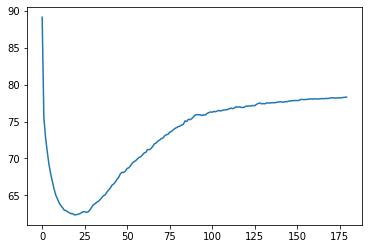

In [13]:
plt.plot(model.forward_backward_angles)

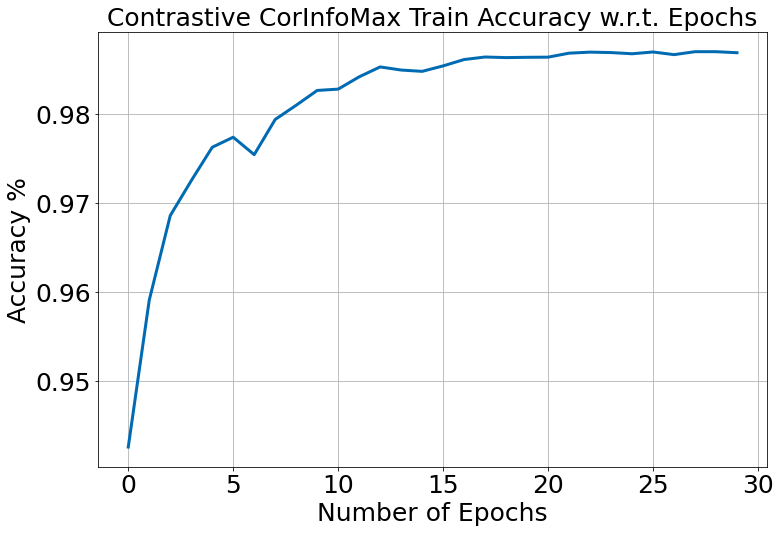

In [14]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

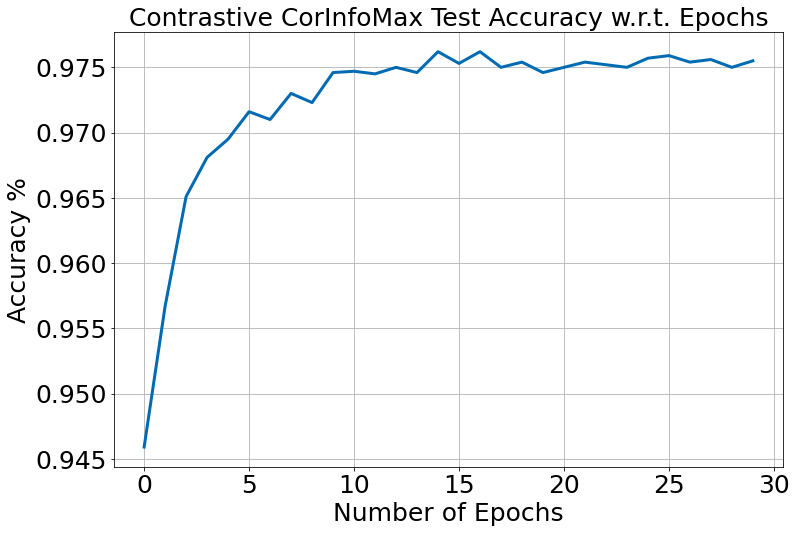

In [15]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [16]:
# from IPython.display import Math, display
# ########### LATEX Style Display Matrix ###############
# def display_matrix(array):
#     """Display given numpy array with Latex format in Jupyter Notebook.
#     Args:
#         array (numpy array): Array to be displayed
#     """
#     data = ""
#     for line in array:
#         if len(line) == 1:
#             data += " %.3f &" % line + r" \\\n"
#             continue
#         for element in line:
#             data += " %.3f &" % element
#         data += r" \\" + "\n"
#     display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [17]:
# display_matrix(model.B[0]['weight'][:10,:10])

In [18]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [19]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [20]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])

In [21]:
# In this section, we present the CorInfoMax network structure and corresponding neuronal dynamics for different selections of $\displaystyle \Pcal^{(k)}$. In particular, we can choose different presumed domain $\displaystyle \Pcal^{(k)}$ for each layer-$k$. To illustrate, consider $\displaystyle \Pcal^{(k)} = \mathcal{B}_{1,+}=\{\rvr: \|\rvr\|_1 \leq 1, \vzero \leq \rvr \}$ that is the intersection of the $L1$ norm ball and the nonnegative orthant. To derive the network dynamics corresponding to $\rvr^{(k)}[t]$, we consider the following constrained optimization similar to (\ref{eq:objsysdynamics}),

# \begin{eqnarray}
#     \underset{\rvr^{(k)}[t]}{\text{maximize }} & \Bigg( \Bigg.\frac{1}{2}(\log \det (\hat{\rmR}_{\rvr^{(k)}}[t]+ \epsilon_{k-1} \mI)+\log \det (\hat{\rmR}_{\rvr^{(k)}}[t]+ \epsilon_{k} \mI))\nonumber\\  &-\frac{1}{2\epsilon_{k-1}}\left\|\overset{\rightarrow}{\rve}^{(k)}[t]\right\|_2^2-\frac{1}{2\epsilon_k}\left\|\overset{\leftarrow}{\rve}^{(k)}[t]\right\|_2^2\Bigg. \Bigg)\label{eq:objsysdynamicsSparse}\\
#     \text{subject to} &  \|\rvr^{(k)}[t]\|_1 \le 1,\nonumber\\
#     &   \mathbf{0}\le \rvr^{(k)}[t],\nonumber
# \end{eqnarray}

# We can write down the Lagrangian min-max problem corresponding to this optimization as 
# \begin{eqnarray}
# \underset{{q}_k[t] \ge 0}{\text{minimize }} 
#  \underset{\rvr^{(k)}[t] \ge \vzero}{\text{maximize }}  L(\rvr^{(k)}[t], {q}_k[t])=O(\rvr^{(k)}[t])+{q}_k[t](\|\rvr^{(k)}[t]\|_1 - 1)
# \end{eqnarray}
# where $O(\rvr^{(k)}[t])$ is the objective in (\ref{eq:objsysdynamicsSparse}). Following the proximal gradient update for $\displaystyle \rvr^{(k)}[t]$ with the gradient expression (\ref{eq:gradrk}), we can write the output dynamics for layer-$k$ as follows, 

# \begin{align}
#     &\tau_{\rvu}\frac{d \rvu^{(k)}[t;s]}{ds}=-g_{lk}\rvu^{(k)}[t;s]+g_{A,k}(\rvv^{(k)}_A[t;s]-\rvu^{(k)}[t;s])+g_{B,k}(\rvv^{(k)}_B[t;s]-\rvu^{(k)}[t;s]), \nonumber%\label{eq:hiddynamicsSparse1}
#     \\
#   &\rvr^{(k)}[t;s]= \text{ReLU}(\rvu^{(k)}[t;s] - q^{(k)}[t;s]) \nonumber, %\label{eq:hiddynamicsSparse2}
#   \end{align}
  
# % \begin{eqnarray}
# %     \tau_{\rvu}\frac{d \rvu^{(k)}[t;s]}{ds}&=&-g_{lk}\rvu^{(k)}[t;s]+\frac{1}{\epsilon_k}\mM^{(k)}[t]\vr^{(k)}[t;s]-\frac{1}{\epsilon_{k-1}}\overset{\rightarrow}{\rve}_u^{(k)}[t;s]-\frac{1}{\epsilon_{k}}\overset{\leftarrow}{\rve}_u^{(k)}[t;s], \nonumber\\
# %    \overset{\rightarrow}{\rve}_u^{(k)}[t;s]&=&\rvu^{(k)}[t;s]-\mW^{(k-1)}_{ff}[t]\rvr^{(k-1)}[t;s], \nonumber\\
# % \overset{\leftarrow}{\rve}_u^{(k)}[t;s]&=&\rvu^{(k)}[t;s]-\mW^{(k)}_{fb}[t]\rvr^{(k+1)}[t;s],\nonumber\\
# % \rvr^{(k)}[t;s]&=& \text{ReLU}(\rvu^{(k)}[t;s] - q^{(k)}[t;s]) \nonumber,
# % \end{eqnarray} 

# where we utilized the intermediate variable $\displaystyle \rvu^{(k)}$, and $\text{ReLU}$ is the element-wise rectified linear unit.
# The update corresponding to the Lagrangian variable $q_1[t;s]$ can be written based on the dual minimization,

# \begin{align}
#     \frac{d a_k[t;s]}{ds} = -a_k[t;s] + \sum_{j = 1}^{N_k} \rvr_j^{(k)}[t;s] - 1 + q^{(k)}[t;s], \quad q^{(k)}[t;s] = \text{ReLU}(a_k[t;s]) \nonumber
# \end{align}

# The Lagrangian variable $\displaystyle q^{(k)}$ in the above formulation corresponds to an additional inhibition inter-neuron that takes input from the whole neurons of layer-$k$ and produces an inhibition signal.